In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from joblib import Parallel, delayed
import seaborn as sns
sns.set_style('white')
sns.set_context('notebook', font_scale=1.3)

from agents import Agent
from mouselab import MouselabEnv
from distributions import Normal, Categorical
from policies import FixedPlanPolicy
from evaluation import *

# Environment

In [4]:
def make_env(depth, cost, ground_truth=False):
    """Returns a MouselabEnv with branching factor 2 and given depth and cost.
    
    If `ground_truth` is True, the reward observed at a given node will be
    constant across runs on this env. This reduces variance of the return."""
    reward = Categorical([-1, 1])
    env = MouselabEnv(2, depth, reward=reward, cost=cost)
    if ground_truth:
        env.ground_truth = np.array([0, *reward.sample(len(env.tree) - 1)])
    return env

def make_envs(depth, cost, n=100, ground_truth=None):
    # Note, ground_truth can be an int in which case it acts as a random seed.
    if ground_truth is not None:
        np.random.seed(ground_truth)
        return [make_env(depth, cost, True) for _ in range(n)]
    else:
        return [make_env(depth, cost, False)] * n

# Regression

In [19]:
from toolz import memoize
from exact import sort_tree
   
def regression_data(env):
    """Returns features and Q* for all(*) state-action pairs in an env.
    
    (*) the state space is reduced by treating symmetric states as one.
    """
    Q, V, pi, info = solve(env, hash_state='sort_tree')
    data = []
    def hash_key(args, kwargs):
        s = args[0]
        if s is None:
            return s
        else:
            return sort_tree(env, s)
    @memoize(key=hash_key)
    def rec(s):
        for a in env.actions(s):
            for p, s1, r in env.results(s, a):
                data.append({
                    'features': env.action_features(a, state=s),
                    'state': s,
                    'action': a,
                    'q_star': Q(s, a)
                })
                rec(s1)
    rec(env.init)
    return pd.DataFrame(data)

In [46]:
from sklearn.linear_model import LinearRegression

def run_regression(df):
    X = np.stack(df.features)
    m = LinearRegression().fit(X, df.q_star)
    df['q_hat'] = m.predict(X)
    error = df['q_hat'] - df['q_star']
    df['abs_error'] = np.abs(error)
    df['square_error'] = error ** 2
    return m.coef_, df.square_error.mean()

In [ ]:
features = [
    'cost',
    'myopic_voc',
    'vpi_action',
    'vpi',
    'expected_term_reward',
]
def run_one(depth, cost):
    env = make_env(depth, cost, None)
    df = pd.DataFrame(regression_data(env))
    coef, mse = run_regression(df)
    return [cost, *coef, mse ]

from joblib import Parallel, delayed

depth = 3
jobs = (delayed(run_one)(depth, cost)
        for cost in np.logspace(-3, 0, 8))
rf = pd.DataFrame(Parallel(n_jobs=8)(jobs))

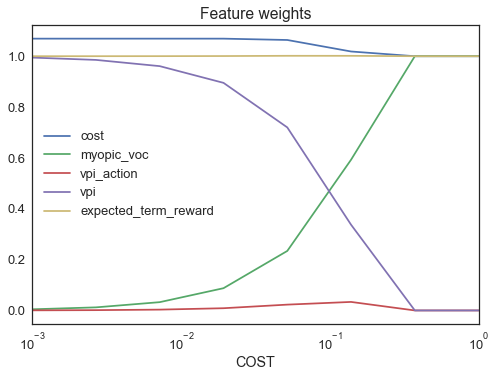

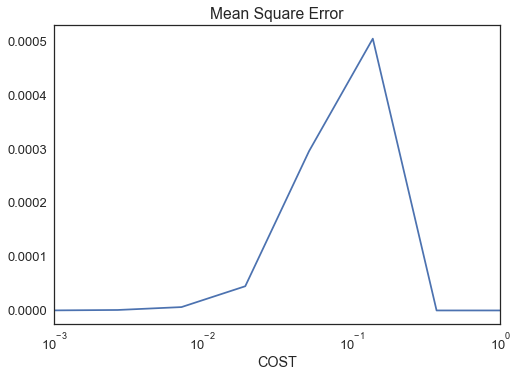

In [54]:
rdf = df
rdf.columns = ['COST', *features, 'MSE']
rdf = rdf.set_index('COST')
rdf.drop('MSE', 1).plot(logx=True, title='Feature weights')
plt.figure()
rdf.MSE.plot(logx=True, title='Mean Square Error')

# plt.plot(coefs[['myopic_voc', 'vpi_action', 'vpi']].sum(axis=1), c='k', ls='--', 
#          label='myopic_voc + vpi_action + vpi')

# Policy learning (via Bayesian Optimization)

In [5]:
import warnings
warnings.filterwarnings("ignore", 
                        message="The objective has been evaluated at this point before.")

[ 5.939  0.715  0.603  0.545  1.   ] -> 1.894 in 1 sec
[ 4.813  0.646  0.438  0.892  1.   ] -> 1.886 in 1 sec
[ 9.673  0.383  0.792  0.529  1.   ] -> 1.886 in 1 sec
[ 6.112  0.926  0.071  0.087  1.   ] -> 1.769 in 1 sec
[ 1.182  0.833  0.778  0.87   1.   ] -> 1.902 in 1 sec
[ 9.808  0.799  0.461  0.781  1.   ] -> 1.886 in 1 sec
[ 2.064  0.64   0.143  0.945  1.   ] -> 1.902 in 1 sec
[ 5.697  0.415  0.265  0.774  1.   ] -> 1.886 in 1 sec
[ 5.105  0.568  0.019  0.618  1.   ] -> 1.886 in 1 sec
[ 6.509  0.617  0.944  0.682  1.   ] -> 1.87 in 1 sec
[ 4.236  0.437  0.698  0.06   1.   ] -> 1.911 in 1 sec
[ 7.001  0.671  0.21   0.129  1.   ] -> 1.924 in 1 sec
[ 3.839  0.364  0.57   0.439  1.   ] -> 1.886 in 1 sec
[ 9.895  0.102  0.209  0.161  1.   ] -> 1.874 in 1 sec
[ 6.878  0.253  0.466  0.244  1.   ] -> 1.873 in 1 sec
[ 2.431  0.11   0.656  0.138  1.   ] -> 1.88 in 1 sec
[ 2.769  0.369  0.821  0.097  1.   ] -> 1.871 in 1 sec
[ 8.542  0.096  0.976  0.469  1.   ] -> 1.87 in 1 sec
[ 9.791  0.60

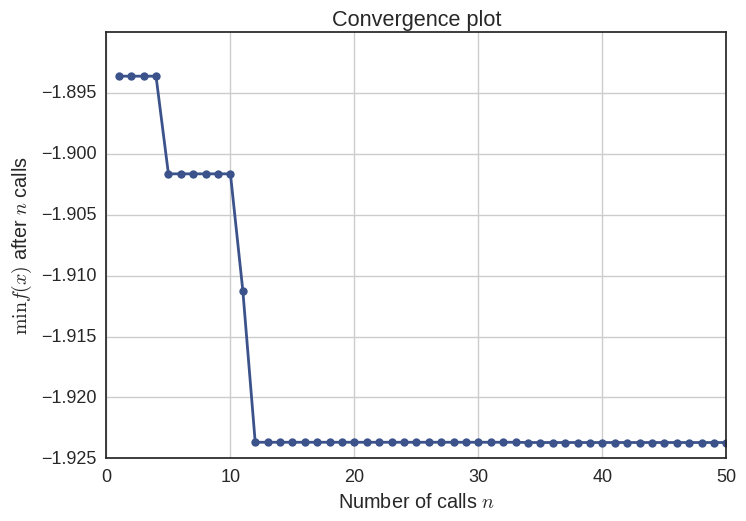

In [6]:
train_envs = make_envs(3, .01, n=1000, ground_truth=None)
pol, result = bo_policy(train_envs, max_cost=10, normalize_voi=False,
                        n_random_starts=20,
                        n_calls=50, verbose=1, n_jobs=25, return_result=True,)

from skopt.plots import plot_convergence, plot_evaluations, plot_objective
plot_convergence(result)

In [81]:
def write_theta(d, c, theta):
    with open('data/discrete_theta.txt', 'a+') as f:
        f.write('{}  {}  {}\n'.format(d, c, theta))
    np.save('data/discrete_{}_{}.npy'.format(d, c), theta)

bo_policies = {}
bo_results = {}
for depth in range(2, 6):
    print('---- {} ----'.format(depth))
    for cost in np.logspace(-3, 0, 7):
        train_envs = make_envs(depth, cost, n=1000)
        pol, result = bo_policy(train_envs, max_cost=len(train_envs[0].tree), normalize_voi=False, n_random_starts=20,
                                n_calls=60, n_jobs=40, return_result=True,)
        c = round(float(cost), 4)
        bo_policies[depth, c] = pol
        bo_results[depth, c] = result
        write_theta(depth, c, pol.theta)
        
    

In [13]:
%%time
env = make_env(3, .001)
pol = blinkered_policy(env)

blinkered -> 1.4027812500000003 in 0.27919519832357764 sec
CPU times: user 280 ms, sys: 4 ms, total: 284 ms
Wall time: 280 ms


In [21]:
envs = make_envs(3, .001, n=100)

%time print(get_util(pol, envs))

1.95415
CPU times: user 116 ms, sys: 12 ms, total: 128 ms
Wall time: 116 ms


In [23]:
lp = LiederPolicy([1, 1, 0, 1, 1])
%time print(get_util(pol, envs))

1.79412
CPU times: user 104 ms, sys: 16 ms, total: 120 ms
Wall time: 113 ms


In [8]:
%%time
env = make_env(3, .1)
optimal_policy(env)

optimal -> 1.4458984375 in 48.3453994137235 sec
CPU times: user 48.3 s, sys: 28 ms, total: 48.3 s
Wall time: 48.3 s


In [59]:
%%time

def run_params(depth=3, cost=.01):
#     print('run_params', depth, cost)
    env = make_env(depth, cost)
    term_action = env.term_action
    policies = {
        'BO': get_bo_policy(depth, cost),
#         'BO' : bo_policies[depth, cost],
        'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),
        'blinkered': blinkered_policy(env),
        # 'optimal': optimal_policy(env),
        'full-observation': FixedPlanPolicy(range(1, term_action+1)),
        # 'none': FixedPlanPolicy([term_action]),
    }
    test_envs = make_envs(depth, cost, n=1000)
    def test():
        # print('test', cost)
        for name, policy in policies.items():
            df = evaluate(policy, envs=test_envs)
            df['agent'] = name
            df['depth'] = depth
            df['cost'] = cost
            yield df
    df = pd.concat(test())
    print('done', depth, cost)
    return df

# with Parallel(n_jobs=48) as parallel:
#     data = parallel(delayed(run_params)(depth, cost)
#                     for cost, depth in bo_policies.keys()
# #                     for depth in range(2, 6)
# #                     for cost in np.logspace(-3, 0, 12)
#                    )
# #     df = pd.concat(data)
df = run_params(4, .05)

JoblibKeyError: JoblibKeyError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    179         sys.exit(msg)
    180     main_globals = sys.modules["__main__"].__dict__
    181     if alter_argv:
    182         sys.argv[0] = mod_spec.origin
    183     return _run_code(code, main_globals, None,
--> 184                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py')
    185 
    186 def run_module(mod_name, init_globals=None,
    187                run_name=None, alter_sys=False):
    188     """Execute a module's code without importing it

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/runpy.py in _run_code(code=<code object <module> at 0x7f7ab4d26f60, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/fredcallaway/miniconda3/lib/python3.5/site...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/fredcallaway/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/fredca.../python3.5/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x7f7ab4d26f60, file "/...3.5/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__builtins__': <module 'builtins' (built-in)>, '__cached__': '/home/fredcallaway/miniconda3/lib/python3.5/site...ges/ipykernel/__pycache__/__main__.cpython-35.pyc', '__doc__': None, '__file__': '/home/fredcallaway/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.5/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/home/fredca.../python3.5/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    648 
    649         If a global instance already exists, this reinitializes and starts it
    650         """
    651         app = cls.instance(**kwargs)
    652         app.initialize(argv)
--> 653         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    654 
    655 #-----------------------------------------------------------------------------
    656 # utility functions, for convenience
    657 #-----------------------------------------------------------------------------

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\n\ndef run_params(depth=3, cost=.01):\n#    ...)\n                   )\n#     df = pd.concat(data)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-09-05T10:47:34.332664', 'msg_id': '285B29DCB6064C9CB8A9492474C5CB37', 'msg_type': 'execute_request', 'session': '282726A7C6304BF2A8E5D781ACF5799C', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '285B29DCB6064C9CB8A9492474C5CB37', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'282726A7C6304BF2A8E5D781ACF5799C']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\n\ndef run_params(depth=3, cost=.01):\n#    ...)\n                   )\n#     df = pd.concat(data)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-09-05T10:47:34.332664', 'msg_id': '285B29DCB6064C9CB8A9492474C5CB37', 'msg_type': 'execute_request', 'session': '282726A7C6304BF2A8E5D781ACF5799C', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '285B29DCB6064C9CB8A9492474C5CB37', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'282726A7C6304BF2A8E5D781ACF5799C'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': '%%time\n\ndef run_params(depth=3, cost=.01):\n#    ...)\n                   )\n#     df = pd.concat(data)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-09-05T10:47:34.332664', 'msg_id': '285B29DCB6064C9CB8A9492474C5CB37', 'msg_type': 'execute_request', 'session': '282726A7C6304BF2A8E5D781ACF5799C', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': '285B29DCB6064C9CB8A9492474C5CB37', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='%%time\n\ndef run_params(depth=3, cost=.01):\n#    ...)\n                   )\n#     df = pd.concat(data)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = '%%time\n\ndef run_params(depth=3, cost=.01):\n#    ...)\n                   )\n#     df = pd.concat(data)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('%%time\n\ndef run_params(depth=3, cost=.01):\n#    ...)\n                   )\n#     df = pd.concat(data)',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('%%time\n\ndef run_params(depth=3, cost=.01):\n#    ...)\n                   )\n#     df = pd.concat(data)',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='%%time\n\ndef run_params(depth=3, cost=.01):\n#    ...)\n                   )\n#     df = pd.concat(data)', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Expr object>], cell_name='<ipython-input-59-f6f255adaebd>', interactivity='last', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 7f79f5ea6ba8, executi..._before_exec=None error_in_exec=None result=None>)
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])
   2826                 code = compiler(mod, cell_name, "single")
-> 2827                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x7f7a0807af60, file "<ipython-input-59-f6f255adaebd>", line 1>
        result = <ExecutionResult object at 7f79f5ea6ba8, executi..._before_exec=None error_in_exec=None result=None>
   2828                     return True
   2829 
   2830             # Flush softspace
   2831             if softspace(sys.stdout, 0):

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x7f7a0807af60, file "<ipython-input-59-f6f255adaebd>", line 1>, result=<ExecutionResult object at 7f79f5ea6ba8, executi..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x7f7a0807af60, file "<ipython-input-59-f6f255adaebd>", line 1>
        self.user_global_ns = {'Agent': <class 'agents.Agent'>, 'Categorical': <class 'distributions.Categorical'>, 'FixedPlanPolicy': <class 'policies.FixedPlanPolicy'>, 'FunctionPolicy': <class 'policies.FunctionPolicy'>, 'In': ['', "get_ipython().magic('matplotlib inline')\n\nimport...s import FixedPlanPolicy\nfrom evaluation import *", 'def make_env(depth, cost, ground_truth=False):\n ...        return [make_env(depth, cost, False)] * n', 'import warnings\nwarnings.filterwarnings("ignore"...ective has been evaluated at this point before.")', 'train_envs = make_envs(3, .01, n=1000, ground_tr...luations, plot_objective\nplot_convergence(result)', 'train_envs = make_envs(3, .01, n=1000, ground_tr...luations, plot_objective\nplot_convergence(result)', 'train_envs = make_envs(3, .01, n=1000, ground_tr...luations, plot_objective\nplot_convergence(result)', 'envs = make_envs(2, .01, 3)', 'envs[0].step(1)', 'envs[1].step(1)', 'envs[2].step(1)', 'envs[2].reset()\nenvs[2].step(1)', 'envs[2].reset()\nenvs[2].step(1)', 'envs[2].reset()\nenvs[2].step(1)', 'envs[1].step(1)', 'envs[1].step(2)', 'envs[1].step(3)', 'envs[0].step(3)', 'envs[0].reset()\nenvs[0].step(1)', 'envs[0].reset()\nenvs[0].step(1)', ...], 'LiederPolicy': <class 'policies.LiederPolicy'>, 'MouselabEnv': <class 'mouselab.MouselabEnv'>, 'Normal': <class 'distributions.Normal'>, 'Out': {5: <matplotlib.axes._subplots.AxesSubplot object>, 6: <matplotlib.axes._subplots.AxesSubplot object>, 8: ((0, 1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 9: ((0, 1, Cat, Cat, Cat, Cat, Cat), 0, False, {}), 10: ((0, 1, Cat, Cat, Cat, Cat, Cat), 0, False, {}), 11: ((0, 1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 12: ((0, -1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 13: ((0, 1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 14: ((0, 1, Cat, Cat, Cat, Cat, Cat), 0, False, {}), 15: ((0, 1, 1, Cat, Cat, Cat, Cat), -0.01, False, {}), ...}, 'Parallel': <class 'joblib.parallel.Parallel'>, ...}
        self.user_ns = {'Agent': <class 'agents.Agent'>, 'Categorical': <class 'distributions.Categorical'>, 'FixedPlanPolicy': <class 'policies.FixedPlanPolicy'>, 'FunctionPolicy': <class 'policies.FunctionPolicy'>, 'In': ['', "get_ipython().magic('matplotlib inline')\n\nimport...s import FixedPlanPolicy\nfrom evaluation import *", 'def make_env(depth, cost, ground_truth=False):\n ...        return [make_env(depth, cost, False)] * n', 'import warnings\nwarnings.filterwarnings("ignore"...ective has been evaluated at this point before.")', 'train_envs = make_envs(3, .01, n=1000, ground_tr...luations, plot_objective\nplot_convergence(result)', 'train_envs = make_envs(3, .01, n=1000, ground_tr...luations, plot_objective\nplot_convergence(result)', 'train_envs = make_envs(3, .01, n=1000, ground_tr...luations, plot_objective\nplot_convergence(result)', 'envs = make_envs(2, .01, 3)', 'envs[0].step(1)', 'envs[1].step(1)', 'envs[2].step(1)', 'envs[2].reset()\nenvs[2].step(1)', 'envs[2].reset()\nenvs[2].step(1)', 'envs[2].reset()\nenvs[2].step(1)', 'envs[1].step(1)', 'envs[1].step(2)', 'envs[1].step(3)', 'envs[0].step(3)', 'envs[0].reset()\nenvs[0].step(1)', 'envs[0].reset()\nenvs[0].step(1)', ...], 'LiederPolicy': <class 'policies.LiederPolicy'>, 'MouselabEnv': <class 'mouselab.MouselabEnv'>, 'Normal': <class 'distributions.Normal'>, 'Out': {5: <matplotlib.axes._subplots.AxesSubplot object>, 6: <matplotlib.axes._subplots.AxesSubplot object>, 8: ((0, 1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 9: ((0, 1, Cat, Cat, Cat, Cat, Cat), 0, False, {}), 10: ((0, 1, Cat, Cat, Cat, Cat, Cat), 0, False, {}), 11: ((0, 1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 12: ((0, -1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 13: ((0, 1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 14: ((0, 1, Cat, Cat, Cat, Cat, Cat), 0, False, {}), 15: ((0, 1, 1, Cat, Cat, Cat, Cat), -0.01, False, {}), ...}, 'Parallel': <class 'joblib.parallel.Parallel'>, ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/home/fredcallaway/mcrl/<ipython-input-59-f6f255adaebd> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 get_ipython().run_cell_magic('time', '', "\ndef run_params(depth=3, cost=.01):\n#     print('run_params', depth, cost)\n    env = make_env(depth, cost)\n    term_action = env.term_action\n    policies = {\n#         'BO': get_bo_policy(depth, cost),\n        'BO' : bo_policies[depth, cost],\n        'meta-greedy': LiederPolicy([1, 1, 0, 0, 1]),\n        'blinkered': blinkered_policy(env),\n        # 'optimal': optimal_policy(env),\n        'full-observation': FixedPlanPolicy(range(1, term_action+1)),\n        # 'none': FixedPlanPolicy([term_action]),\n    }\n    test_envs = make_envs(depth, cost, n=1000)\n    def test():\n        # print('test', cost)\n        for name, policy in policies.items():\n            df = evaluate(policy, envs=test_envs)\n            df['agent'] = name\n            df['depth'] = depth\n            df['cost'] = cost\n            yield df\n    df = pd.concat(test())\n    print('done', depth, cost)\n    return df\n\nwith Parallel(n_jobs=48) as parallel:\n    data = parallel(delayed(run_params)(depth, cost)\n                    for cost, depth in bo_policies.keys()\n#                     for depth in range(2, 6)\n#                     for cost in np.logspace(-3, 0, 12)\n                   )\n#     df = pd.concat(data)")
      7 
      8 
      9 
     10 

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py in run_cell_magic(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, magic_name='time', line='', cell='\ndef run_params(depth=3, cost=.01):\n#     print(...)\n                   )\n#     df = pd.concat(data)')
   2110             # This will need to be updated if the internal calling logic gets
   2111             # refactored, or else we'll be expanding the wrong variables.
   2112             stack_depth = 2
   2113             magic_arg_s = self.var_expand(line, stack_depth)
   2114             with self.builtin_trap:
-> 2115                 result = fn(magic_arg_s, cell)
        result = undefined
        fn = <bound method ExecutionMagics.time of <IPython.core.magics.execution.ExecutionMagics object>>
        magic_arg_s = ''
        cell = '\ndef run_params(depth=3, cost=.01):\n#     print(...)\n                   )\n#     df = pd.concat(data)'
   2116             return result
   2117 
   2118     def find_line_magic(self, magic_name):
   2119         """Find and return a line magic by name.

...........................................................................
/home/fredcallaway/mcrl/<decorator-gen-59> in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell='\ndef run_params(depth=3, cost=.01):\n#     print(...)\n                   )\n#     df = pd.concat(data)', local_ns=None)
      1 
----> 2 
      3 
      4 
      5 
      6 
      7 
      8 
      9 
     10 

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/IPython/core/magic.py in <lambda>(f=<function ExecutionMagics.time>, *a=(<IPython.core.magics.execution.ExecutionMagics object>, '', '\ndef run_params(depth=3, cost=.01):\n#     print(...)\n                   )\n#     df = pd.concat(data)', None), **k={})
    183     validate_type(magic_kind)
    184 
    185     # This is a closure to capture the magic_kind.  We could also use a class,
    186     # but it's overkill for just that one bit of state.
    187     def magic_deco(arg):
--> 188         call = lambda f, *a, **k: f(*a, **k)
        f = <function ExecutionMagics.time>
        a = (<IPython.core.magics.execution.ExecutionMagics object>, '', '\ndef run_params(depth=3, cost=.01):\n#     print(...)\n                   )\n#     df = pd.concat(data)', None)
        k = {}
    189 
    190         if callable(arg):
    191             # "Naked" decorator call (just @foo, no args)
    192             func = arg

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/IPython/core/magics/execution.py in time(self=<IPython.core.magics.execution.ExecutionMagics object>, line='', cell='\ndef run_params(depth=3, cost=.01):\n#     print(...)\n                   )\n#     df = pd.concat(data)', local_ns=None)
   1175             st = clock2()
   1176             out = eval(code, glob, local_ns)
   1177             end = clock2()
   1178         else:
   1179             st = clock2()
-> 1180             exec(code, glob, local_ns)
        code = <code object <module> at 0x7f79f5ebad20, file "<timed exec>", line 2>
        glob = {'Agent': <class 'agents.Agent'>, 'Categorical': <class 'distributions.Categorical'>, 'FixedPlanPolicy': <class 'policies.FixedPlanPolicy'>, 'FunctionPolicy': <class 'policies.FunctionPolicy'>, 'In': ['', "get_ipython().magic('matplotlib inline')\n\nimport...s import FixedPlanPolicy\nfrom evaluation import *", 'def make_env(depth, cost, ground_truth=False):\n ...        return [make_env(depth, cost, False)] * n', 'import warnings\nwarnings.filterwarnings("ignore"...ective has been evaluated at this point before.")', 'train_envs = make_envs(3, .01, n=1000, ground_tr...luations, plot_objective\nplot_convergence(result)', 'train_envs = make_envs(3, .01, n=1000, ground_tr...luations, plot_objective\nplot_convergence(result)', 'train_envs = make_envs(3, .01, n=1000, ground_tr...luations, plot_objective\nplot_convergence(result)', 'envs = make_envs(2, .01, 3)', 'envs[0].step(1)', 'envs[1].step(1)', 'envs[2].step(1)', 'envs[2].reset()\nenvs[2].step(1)', 'envs[2].reset()\nenvs[2].step(1)', 'envs[2].reset()\nenvs[2].step(1)', 'envs[1].step(1)', 'envs[1].step(2)', 'envs[1].step(3)', 'envs[0].step(3)', 'envs[0].reset()\nenvs[0].step(1)', 'envs[0].reset()\nenvs[0].step(1)', ...], 'LiederPolicy': <class 'policies.LiederPolicy'>, 'MouselabEnv': <class 'mouselab.MouselabEnv'>, 'Normal': <class 'distributions.Normal'>, 'Out': {5: <matplotlib.axes._subplots.AxesSubplot object>, 6: <matplotlib.axes._subplots.AxesSubplot object>, 8: ((0, 1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 9: ((0, 1, Cat, Cat, Cat, Cat, Cat), 0, False, {}), 10: ((0, 1, Cat, Cat, Cat, Cat, Cat), 0, False, {}), 11: ((0, 1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 12: ((0, -1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 13: ((0, 1, Cat, Cat, Cat, Cat, Cat), -0.01, False, {}), 14: ((0, 1, Cat, Cat, Cat, Cat, Cat), 0, False, {}), 15: ((0, 1, 1, Cat, Cat, Cat, Cat), -0.01, False, {}), ...}, 'Parallel': <class 'joblib.parallel.Parallel'>, ...}
        local_ns = None
   1181             end = clock2()
   1182             out = None
   1183         wall_end = wtime()
   1184         # Compute actual times and report

...........................................................................
/home/fredcallaway/mcrl/<timed exec> in <module>()
     25 
     26 
     27 
     28 
     29 
---> 30 
     31 
     32 
     33 
     34 

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=Parallel(n_jobs=48), iterable=<generator object <genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=48)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
KeyError                                           Tue Sep  5 10:47:35 2017
PID: 112887          Python 3.5.2: /home/fredcallaway/miniconda3/bin/python
...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/joblib/parallel.py in __call__(self=<joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function run_params>, (3, 1.0), {})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/fredcallaway/miniconda3/lib/python3.5/site-packages/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function run_params>
        args = (3, 1.0)
        kwargs = {}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/home/fredcallaway/mcrl/<timed exec> in run_params(depth=3, cost=1.0)
      3 
      4 
      5 
      6 
      7 
----> 8 
      9 
     10 
     11 
     12 

KeyError: (3, 1.0)
___________________________________________________________________________

(-0.5, 1)

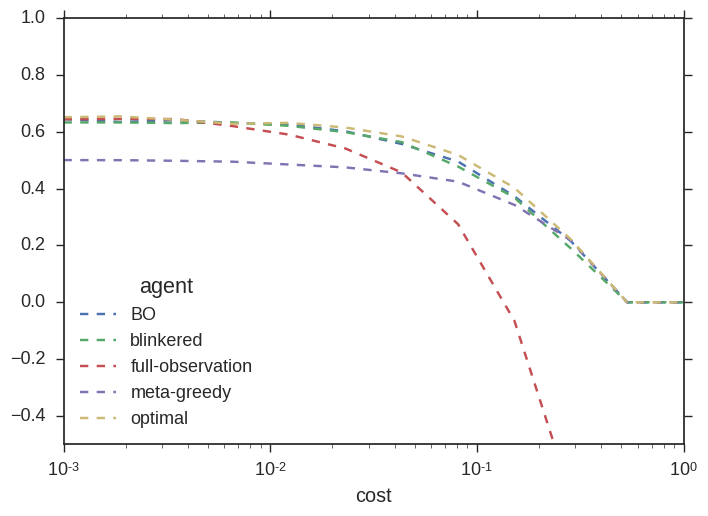

In [39]:
df.groupby('cost agent'.split()).rate.mean().unstack().plot(logx=True, ls='--')
plt.ylim(-.5,1)

(-2, 2)

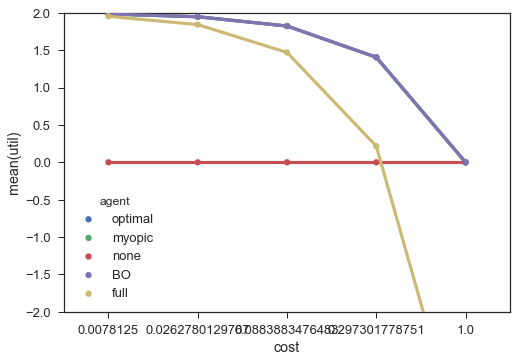

In [18]:
sns.set_style('ticks')
sns.pointplot('cost', 'util', hue='agent', data=df1, markers='.', size=(4,4), )
plt.ylim(-2, 2)

# Scratch